### Main evaluation code

In [1]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


(520, 696, 2)


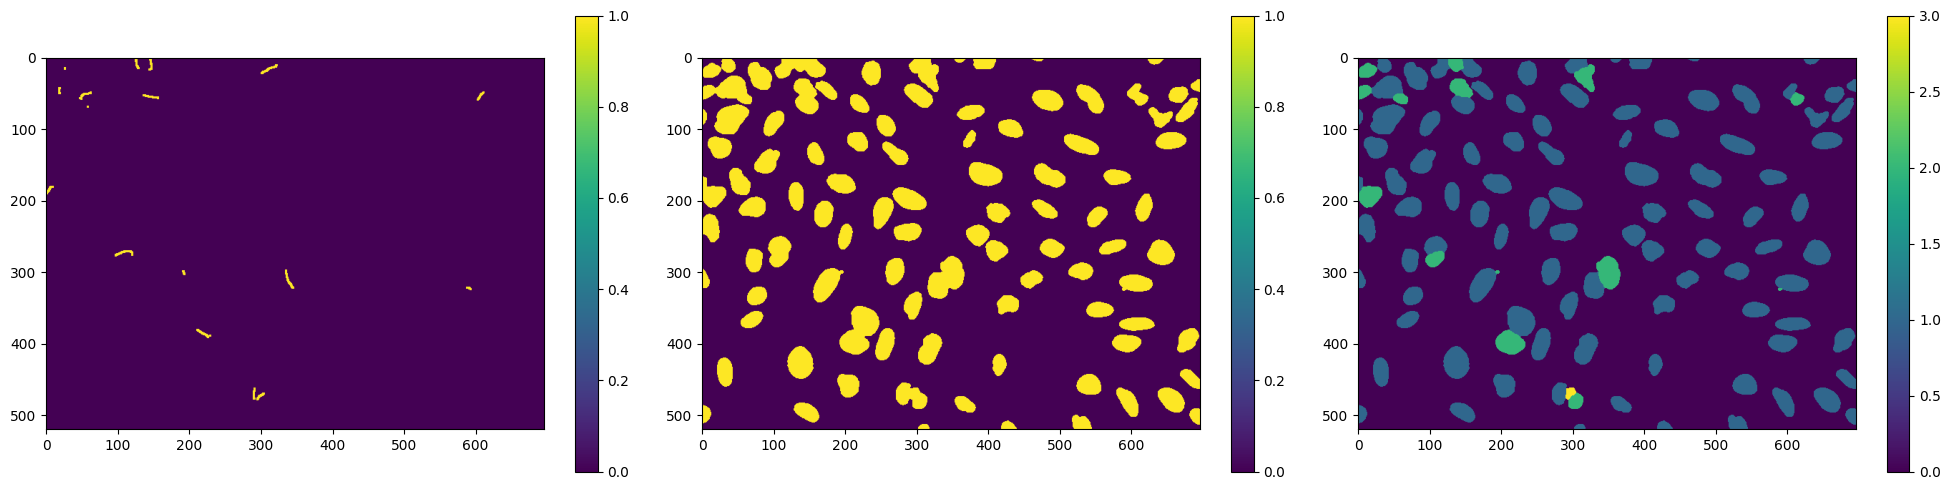

In [2]:
import cv2
import matplotlib.pyplot as plt
from mwm.components.image_processing import get_gt_mask_png

mask_path = "artifacts/data_ingestion/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png"
mask_raw = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
mask_raw = cv2.cvtColor(mask_raw, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

mask = get_gt_mask_png(mask_raw[:,:,0])[:,:,1:] # leave out the 1st channel (empty), [0 1]

print(mask.shape)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.colorbar(ax[0].imshow(mask[:,:,0]), ax=ax[0])
fig.colorbar(ax[1].imshow(mask[:,:,1]), ax=ax[1])
fig.colorbar(ax[2].imshow(mask_raw[:,:,0]), ax=ax[2])
plt.tight_layout()
plt.show()

95


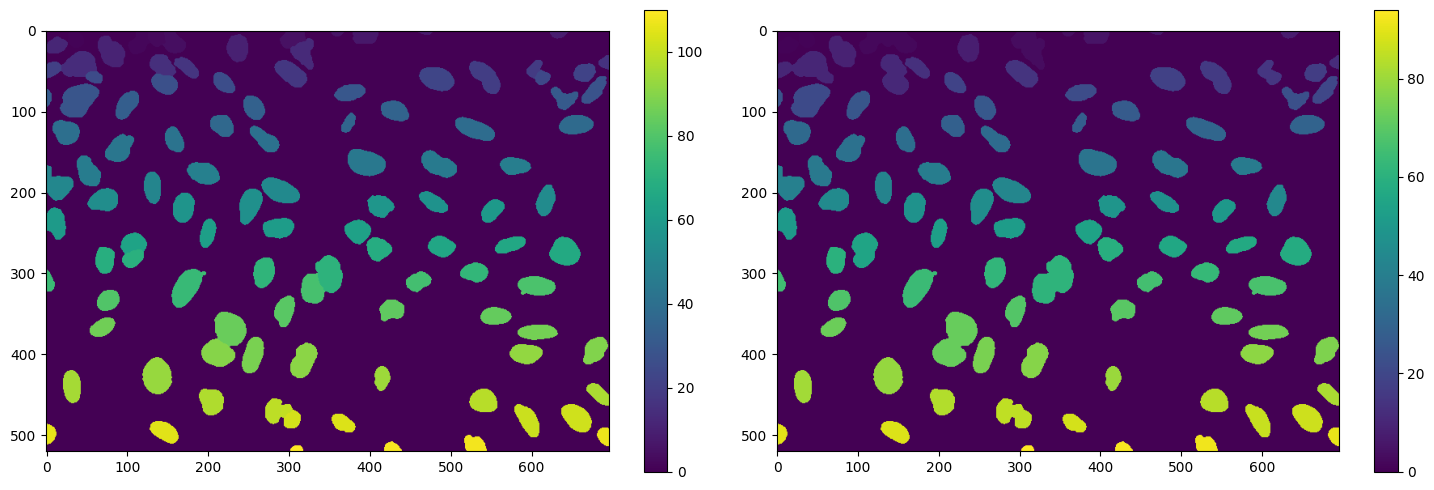

In [3]:
import numpy as np
from skimage import measure
from skimage.morphology import dilation, footprint_rectangle

labels_raw = measure.label(mask_raw[:,:,0], background=0)

labels_mask_gt = measure.label(mask[:,:,-1], background=0)
# labels_mask_gt = dilation(labels_mask_gt, footprint_rectangle((3, 3)))
print(len(np.unique(labels_mask_gt)))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(labels_raw), ax=ax[0])
fig.colorbar(ax[1].imshow(labels_mask_gt), ax=ax[1])
plt.tight_layout()
plt.show()

In [4]:
import numpy as np

def iou_object_labels(ground_truth, prediction):
    """
    Compute the pixel-level segmentation IoU for multiple objects in one image sample.
    Args:
        - ground_truth: 2D numpy array (int), ground truth mask, each object identified by pixels with the same unique value
        - prediction: 2D numpy array (int), predicted mask, each object identified by pixels with the same unique value
    Returns:
        - iou_matrix: 2D numpy array (float), IoU matrix for each object pair
    """
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    iou_matrix = intersection/union
    
    return iou_matrix


def measures_at(threshold, iou_matrix):
    """
    Object level evaluation metrics at a given IoU threshold.
    Args:
        - threshold: float, IoU threshold
        - iou_matrix: 2D numpy array (float), IoU matrix for each object pair
    Returns:
        - f1: float, F1 score
        - precision: float, precision
        - recall: float, recall
        - jaccard: float, Jaccard index
        - TP: int, number of true positives objects identified in a image sample
        - FP: int, number of false positives objects identified in a image sample
        - FN: int, number of false negatives objects identified in a image sample
    """
    
    matches = iou_matrix > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    jaccard = TP / (TP + FP + FN + 1e-9)
    
    return f1, precision, recall, jaccard, TP, FP, FN

In [9]:
import pandas as pd
from skimage import measure
from mwm.components.image_processing import read_image_png, post_processing_watershed_2ch
import mlflow


class EvaluationProcessor2Channel:
    def __init__(self):
        self.results = []
        self.thresholds = np.round(np.arange(0.5, 1.0, 0.05), 2)


    def prep_evaluation(self, prediction, mask_path):
        self.sample_name = os.path.basename(mask_path).split(".")[0]

        # Convert orginal mask to label
        mask_raw = read_image_png(mask_path)
        self.labels_gt = measure.label(mask_raw[:,:,0], background=0)

        # Convert prediction output to label: 
        prediction = prediction.permute(1, 2, 0).cpu().numpy()
        # TODO: add future denoising step before thresholding
        prediction = (prediction > 0.5).astype(np.uint8)
        reconstruction = post_processing_watershed_2ch(prediction) # key post-processing logic
        self.labels_pred = reconstruction[:mask_raw.shape[0], :mask_raw.shape[1]] # remove padding
            

    def update_metrics(self):
        iou_matrix = iou_object_labels(self.labels_gt, self.labels_pred)
        if iou_matrix.shape[0] > 0:
            mean_object_iou = np.max(iou_matrix, axis=0).mean()
        else:
            mean_object_iou = 0.0
        
        # Calculate F1 score at all thresholds
        for t in self.thresholds:
            f1, precision, recall, jaccard, tp, fp, fn = measures_at(t, iou_matrix)
            res = {
                "Sample": self.sample_name, 
                "Threshold": t, 
                "F1": f1, 
                "Precision": precision, 
                "Recall": recall, 
                "Jaccard": jaccard, 
                "MeanObjectIoU": mean_object_iou,
                "TP": tp, 
                "FP": fp, 
                "FN": fn
                }
            self.results.append(res)
    

    def log_key_metrics_to_mlflow(self):
        df = pd.DataFrame(self.results)
        df_agg = df.drop(columns=["Sample"]).groupby("Threshold").mean().reset_index().sort_values("Threshold", ascending=True)
        df_agg_list = df_agg.to_dict("records")
        for row_dict in df_agg_list:
            metrics = {k: v for k, v in row_dict.items() if k != "Threshold"}
            mlflow.log_metrics(metrics, step=int(row_dict["Threshold"]*100))
        mlflow.log_metric("MAF1", df_agg["F1"].mean())
        mlflow.log_metric("MAPrecision", df_agg["Precision"].mean())
        mlflow.log_metric("MARecall", df_agg["Recall"].mean())
        mlflow.log_metric("MAJaccard", df_agg["Jaccard"].mean())
        mlflow.log_param("thresholds", self.thresholds)


    def save_results(self, output_path):
        df = pd.DataFrame(self.results)
        df.to_csv(output_path, index=False)

In [ ]:
from tqdm import tqdm
from datetime import datetime

from mwm.constants import *
from mwm.utils.common import read_yaml, load_json
from mwm.components.model_architecture import *
from mwm.components.dataset import *

class Evaluator():
    def __init__(
        self,
        model_path,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
    ):
        self.config = read_yaml(config_filepath)
        self.params = load_json(params_filepath)

        # Make & load model
        self.model = make_model(self.params.network, self.params.encoder_weights)
        self.model_path = model_path
        self.model.load_state_dict(torch.load(model_path))

        # Make dataset
        self.image_dir = os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.image_dir)
        self.mask_dir = os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.mask_dir)
        with open(os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.test_set_file), "r") as f:
            self.image_list_test = f.read().splitlines()
        self.test_dataset = make_dataset(self.params.dataset, self.image_dir, self.mask_dir, self.image_list_test)

        # Make save path (optional)
        if self.params.save_predictions:
            model_name = os.path.basename(self.model_path).split(".")[0]
            self.save_dir = os.path.join(self.config.evaluation.evaluation_dir, f"{model_name}_predictions")
            os.makedirs(self.save_dir, exist_ok=True)


    def handle_device(self):
        # Move model to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)


    def evaluate(self):
        self.evaluate_processor = EvaluationProcessor2Channel()
        # Set model to evaluation mode
        self.model.eval()

        # Evaluate individual sample without batching
        batch_progress_bar = tqdm(self.test_dataset, desc=f"Evaluation", leave=True)
        with torch.no_grad():
            for image, mask in batch_progress_bar:
                mask_path = self.test_dataset.get_mask_path()

                # image = image.to(self.device)

                # # TODO: move to Dataset
                # # Pad images to match the target size
                # image = self.pad_images(image)

                # # TODO: any potnetial issue with not using data loader?
                # image = image.to(self.device).unsqueeze(0)  # Add batch dimension

                # output = self.model(image).squeeze()
                
                # test evaluation using GT mask
                output = self.pad_images(mask)

                self.evaluate_processor.prep_evaluation(output, mask_path)
                self.evaluate_processor.update_metrics()

                if self.params.save_predictions:
                    save_path = os.path.join(self.save_dir, os.path.basename(mask_path))

                    # One-off: just so mask is saved in a image-viewer friendly format
                    # mask_raw = read_image_png(mask_path)
                    # mask_raw_uint8 = (normalize_image(mask_raw[:,:,0]) * 255.).astype(np.uint8)
                    # cv2.imwrite(os.path.join("artifacts/evaluation/mask_label_raw_vis", os.path.basename(mask_path)), mask_raw_uint8)
                    
                    mask_pred = output.permute(1, 2, 0).cpu().numpy()
                    mask_pred_uint8 = (mask_pred > 0.5).astype(np.uint8)
                    empty_channel = np.zeros_like(mask_pred_uint8[:,:,0])
                    mask_pred_uint8 = np.stack([mask_pred_uint8[:,:,1], empty_channel, mask_pred_uint8[:,:,0]], axis=-1) * 255 # cv2 uses BGR
                    cv2.imwrite(save_path, mask_pred_uint8)


        mlflow.set_experiment("Evaluation")
        with mlflow.start_run():

            self.evaluate_processor.log_key_metrics_to_mlflow()

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = os.path.join(
                self.config.evaluation.evaluation_dir,
                f"evaluation_{timestamp}_on_{os.path.basename(self.model_path).split('.')[0]}.csv"
            )
            self.evaluate_processor.save_results(save_path)

            mlflow.log_param("evaluation_save_path", save_path)

            # TODO: change back after GT mask sanity check
            # mlflow.log_param("model_path", self.model_path)
            # test gt mask
            mlflow.log_param("mask_path", "n/a. Evaluate GT mask vs GT labels.")
                

    # TODO: do this in Dataset: use crop and set image_size as a param
    @staticmethod
    def pad_images(images, target_height=544, target_width=704):
        """
        (Move to Dataset class and consider more flexible resizing options: crop, etc.)
        """
        import torch.nn.functional as F
        height, width = images.shape[-2], images.shape[-1]
        pad_height = target_height - height
        pad_width = target_width - width
        padding = (0, pad_width, 0, pad_height, 0, 0)  # (left, right, top, bottom)
        return F.pad(images, padding, mode='constant', value=0)

/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
evaluator = Evaluator("artifacts/models/model_epoch1_20250224_112303.pth")
evaluator.handle_device()
evaluator.evaluate()

[2025-03-07 15:46:24,740: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-03-07 15:46:24,810: INFO: common: json file loaded succesfully from: params.json]
[2025-03-07 15:46:25,391: INFO: model_architecture: Model: unet_resnet34_2ch successfully created. ]
[2025-03-07 15:46:25,467: INFO: dataset: Dataset: seg_2ch successfully processed. ]


Evaluation: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


### Analyze GT mask vs GT labels: sanity check

#### Helper functions

In [ ]:
from skimage.segmentation import watershed

def postprocess_victor(pred):
    av_pred = pred / 255.
    av_pred = av_pred[..., 2] * (1 - av_pred[..., 1])
    av_pred = 1 * (av_pred > 0.5)
    av_pred = av_pred.astype(np.uint8)

    y_pred = measure.label(av_pred, neighbors=8, background=0) # nuclei with splitting lines in black?, labelled

    # remove noise
    props = measure.regionprops(y_pred)
    for i in range(len(props)):
        if props[i].area < 12:
            y_pred[y_pred == i + 1] = 0

    y_pred = measure.label(y_pred, neighbors=8, background=0) # nuclei with splitting lines in black?, labelled

    nucl_msk = (255 - pred[..., 2]) # bkg?
    nucl_msk = nucl_msk.astype('uint8')
    y_pred = watershed(nucl_msk, y_pred, mask=((pred[..., 2] > 80)), watershed_line=True)
    return y_pred

In [ ]:
import seaborn as sns

def vis_metrics(df):
    for thresh in np.arange(0.5, 1.0, 0.1):
        threshold = np.round(thresh, 2)
        df_thresh = df[df["Threshold"] == threshold]
        df_long = df_thresh.drop(columns=["Sample", "Threshold"]).melt(var_name="Metrics", value_name="Value")

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        sns.barplot(df_long[df_long["Metrics"].isin(["F1","Precision","Recall","Jaccard","MeanObjectIoU"])], x="Metrics", y="Value", estimator=np.mean, errorbar='sd', capsize=0.2, color='lightblue', ax=ax[0])
        sns.stripplot(df_long[df_long["Metrics"].isin(["F1","Precision","Recall","Jaccard","MeanObjectIoU"])], x="Metrics", y="Value", color='blue', jitter=True, alpha=0.5, ax=ax[0])
        sns.barplot(df_long[df_long["Metrics"].isin(["TP","FP","FN"])], x="Metrics", y="Value", estimator=np.mean, errorbar='sd', capsize=0.2, color='lightblue', ax=ax[1])
        sns.stripplot(df_long[df_long["Metrics"].isin(["TP","FP","FN"])], x="Metrics", y="Value", color='blue', jitter=True, alpha=0.5, ax=ax[1])
        plt.suptitle(f"Threshold: {threshold}")
        plt.tight_layout()
        plt.show()

#### Read Evaluation result: GT mask vs labels

In [10]:
df = pd.read_csv("artifacts/evaluation/evaluation_20250304_110106_on_model_epoch1_20250224_112303.csv")
print(len(df))
df.head()

500


,Sample,Threshold,F1,Precision,Recall,Jaccard,MeanObjectIoU,TP,FP,FN
0,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.50,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
1,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.55,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
2,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.60,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
3,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.65,0.878613,0.800000,0.974359,0.783505,0.809953,152,38,4
4,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.70,0.878613,0.800000,0.974359,0.783505,0.809953,152,38,4


In [ ]:
# Analyze sub-samples with low MeanObjectIoU

df_sub = df[["Sample", "MeanObjectIoU"]]
df_1 = df_sub[df_sub["MeanObjectIoU"] < 0.84].groupby(["Sample", "MeanObjectIoU"]).mean().reset_index()

#### Analyze individual examples
GT mask design conclusion:
- Still 2 channels needed: 1 for full_foreground, 1 for split_lines

TODO: 
- √ Change GT mask in dataset/ image_preprocessing
- √ Change post processing accordingly: leave a TODO: futurn denoise may be needed for actual prediction outputs
- √ Varify with high-scoring samples (-> ALL samples) to confirm new mask design 

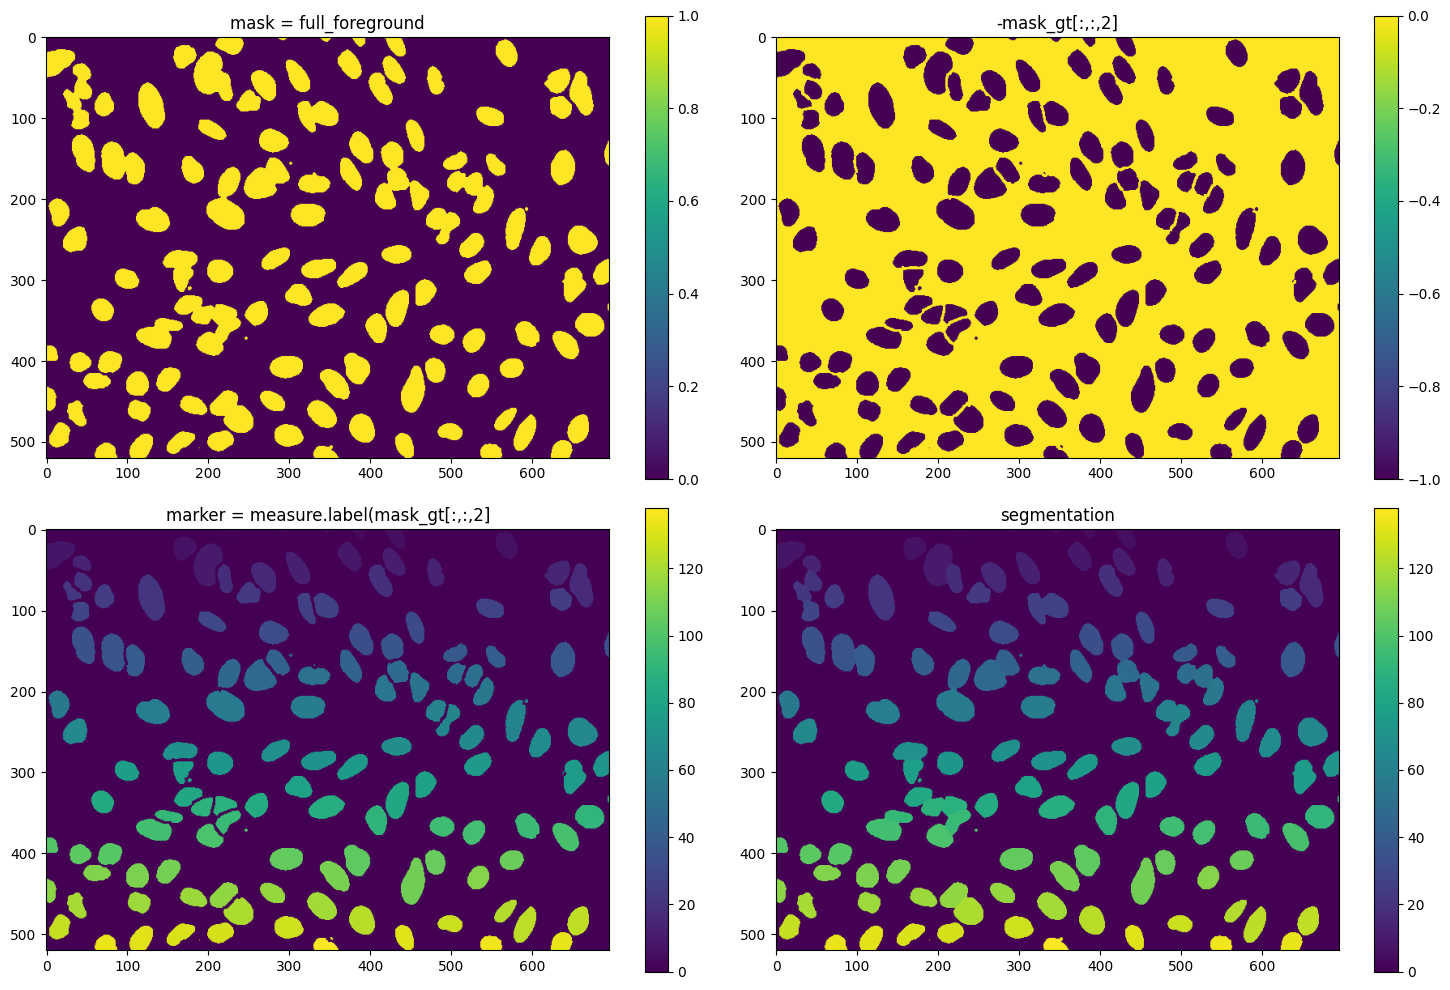

In [ ]:
sample_name = 'IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB57AA9A55'
# Mean F1: 0.9913357400686236
# Mean Jacard: 0.9829022982151759
# Mean MeanObjectIoU: 0.9953383741842267

# 'IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C': 0.927 
# Mean F1: 0.8616541353318674
# Mean Jacard: 0.7805852327137519
# Mean MeanObjectIoU: 0.9271441521270744

mask_label_raw = cv2.imread(f"artifacts/evaluation/mask_label_raw_vis/{sample_name}.png")
mask_label_raw = mask_label_raw[:,:,0] # 3 channel has the same values
full_foreground = (mask_label_raw > 0).astype(int)

mask_gt = plt.imread(f"artifacts/evaluation/mask_gt_vis/{sample_name}.png") # RGB
split = mask_gt[:,:,1]

marker = measure.label(mask_gt[:,:,2], background=0)

segmentation = watershed(
    -mask_gt[:,:,2], # - (full_foreground - split_lines)
    marker, # measure.label((full_foreground - split_lines))
    mask=full_foreground
)
# GT mask design conclusion:
# - Still 2 channels needed: 1 for full_foreground, 1 for split_lines

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.colorbar(ax[0][0].imshow(full_foreground), ax=ax[0][0])
ax[0][0].set_title("mask = full_foreground")
fig.colorbar(ax[0][1].imshow(-mask_gt[:,:,2]), ax=ax[0][1])
ax[0][1].set_title("-mask_gt[:,:,2]")
fig.colorbar(ax[1][0].imshow(marker), ax=ax[1][0])
ax[1][0].set_title("marker = measure.label(mask_gt[:,:,2]")
fig.colorbar(ax[1][1].imshow(segmentation), ax=ax[1][1])
ax[1][1].set_title("segmentation")
plt.tight_layout()
plt.show()

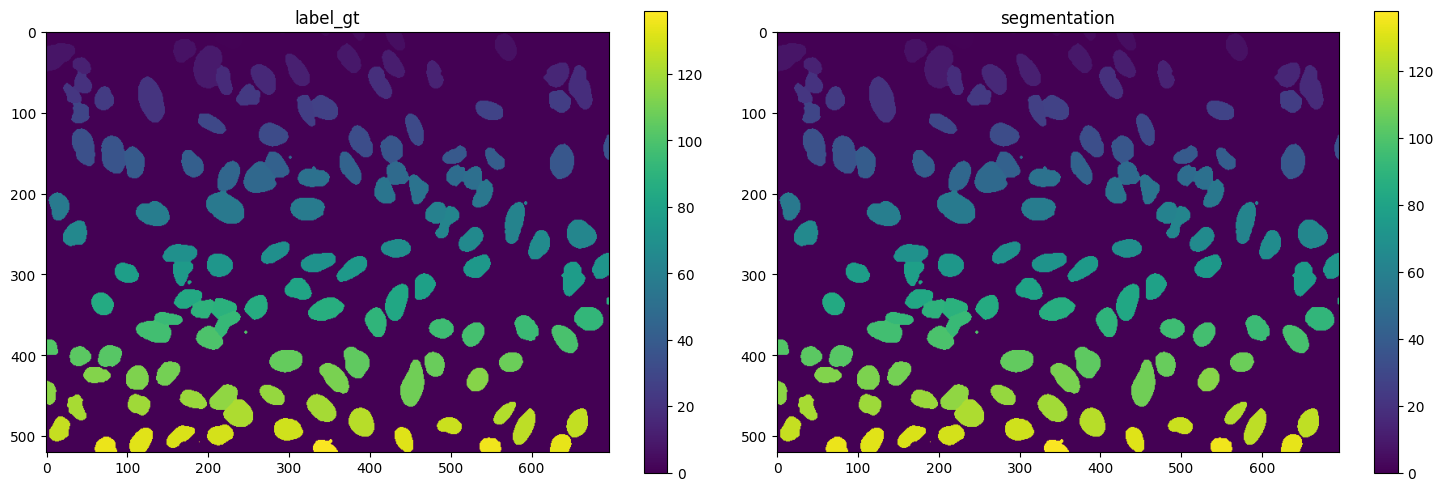

In [77]:
label_gt = measure.label(mask_label_raw, background=0)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(label_gt), ax=ax[0])
ax[0].set_title("label_gt")
fig.colorbar(ax[1].imshow(segmentation), ax=ax[1])
ax[1].set_title("segmentation")
plt.tight_layout()
plt.show()

In [78]:
iou_matrix = iou_object_labels(label_gt, segmentation)
if iou_matrix.shape[0] > 0:
    mean_object_iou = np.max(iou_matrix, axis=0).mean()
else:
    mean_object_iou = 0.0

# Calculate F1 score at all thresholds
results = []
for t in np.round(np.arange(0.5, 1.0, 0.05), 2):
    f1, precision, recall, jaccard, tp, fp, fn = measures_at(t, iou_matrix)
    res = {
        "Sample": sample_name, 
        "Threshold": t, 
        "F1": f1, 
        "Precision": precision, 
        "Recall": recall, 
        "Jaccard": jaccard, 
        "MeanObjectIoU": mean_object_iou,
        "TP": tp, 
        "FP": fp, 
        "FN": fn
        }
    results.append(res)

df_sample_metrics = pd.DataFrame(results)
print(f"Mean F1: {df_sample_metrics['F1'].mean()}")
print(f"Mean Jacard: {df_sample_metrics['Jaccard'].mean()}")
print(f"Mean MeanObjectIoU: {df_sample_metrics['MeanObjectIoU'].mean()}")
df_sample_metrics

Mean F1: 0.9913357400686236
Mean Jacard: 0.9829022982151759
Mean MeanObjectIoU: 0.9953383741842267


,Sample,Threshold,F1,Precision,Recall,Jaccard,MeanObjectIoU,TP,FP,FN
0,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.50,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
1,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.55,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
2,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.60,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
3,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.65,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
4,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.70,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
5,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.75,0.996390,1.000000,0.992806,0.992806,0.995338,138,0,1
6,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.80,0.989170,0.992754,0.985612,0.978571,0.995338,137,1,2
7,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.85,0.981949,0.985507,0.978417,0.964539,0.995338,136,2,3
8,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.90,0.981949,0.985507,0.978417,0.964539,0.995338,136,2,3
9,IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB5...,0.95,0.981949,0.985507,0.978417,0.964539,0.995338,136,2,3


In [ ]:
df_1.Sample.unique()

array(['IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637',
       'IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C',
       'IXMtest_C07_s5_w12C9F2926-A017-4962-8660-72C9C20C86E4',
       'IXMtest_D06_s8_w1BE84C8EF-4CD0-4B56-8267-4E662F57AC25',
       'IXMtest_D08_s7_w1F476A544-A07C-4E9B-A6CB-BAEF4CD6F64E',
       'IXMtest_D20_s3_w19D371AF3-0189-48A3-AF3B-D108DE6A017F',
       'IXMtest_E07_s1_w1641C6847-142B-463F-8B08-5B3296615572',
       'IXMtest_F03_s5_w1FE22EC7D-720A-4848-888A-6AFE1E1C85B0',
       'IXMtest_I12_s1_w18A06F07F-CD8F-4056-B041-3967BE48AD78',
       'IXMtest_I17_s7_w1BB3D534E-DF08-4F21-BAC6-6B105BB40AF9',
       'IXMtest_K01_s5_w1A3DE001A-72D6-4321-8B25-4300AB0207AC',
       'IXMtest_K03_s5_w1DC4CE558-042C-482E-8CAE-FCCB57AA9A55',
       'IXMtest_K05_s9_w1647AEF60-D7B0-4D83-AFA5-2B05E968468F',
       'IXMtest_L06_s5_w1610AE208-D6E8-4DC4-AC19-D26284AA8556',
       'IXMtest_M12_s7_w193E9BA0F-274A-4EE8-A0F0-6A58471A333A',
       'IXMtest_N11_s4_w142A84EA3-47C3-4

##### Individual sample plots

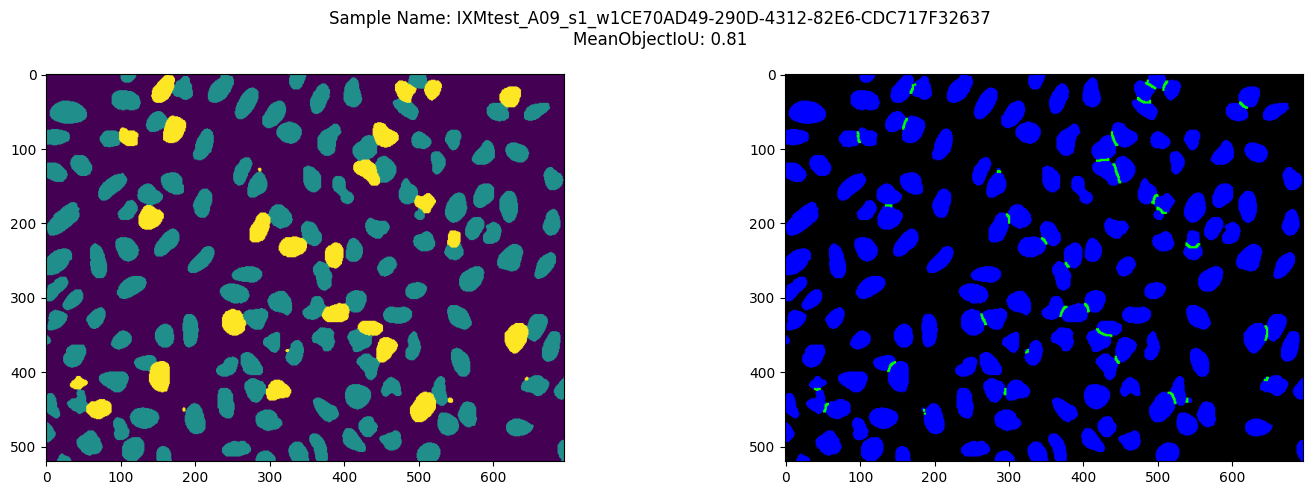

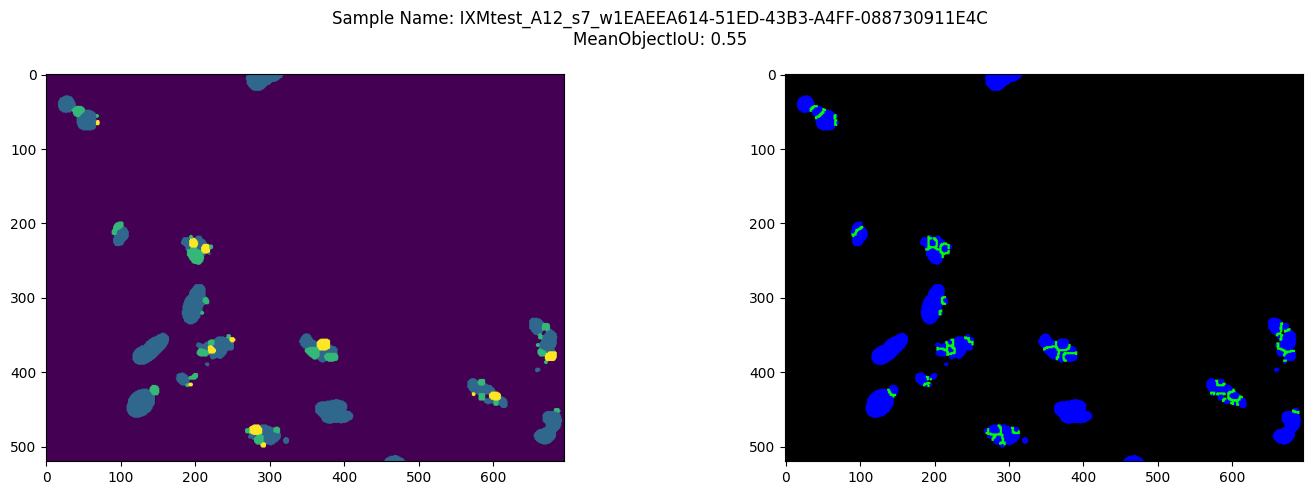

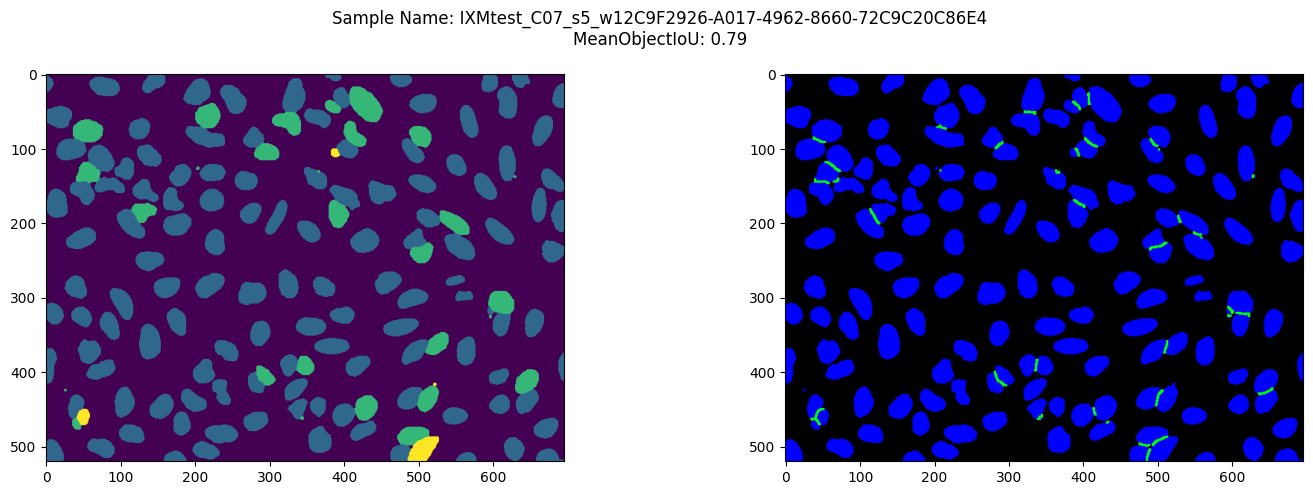

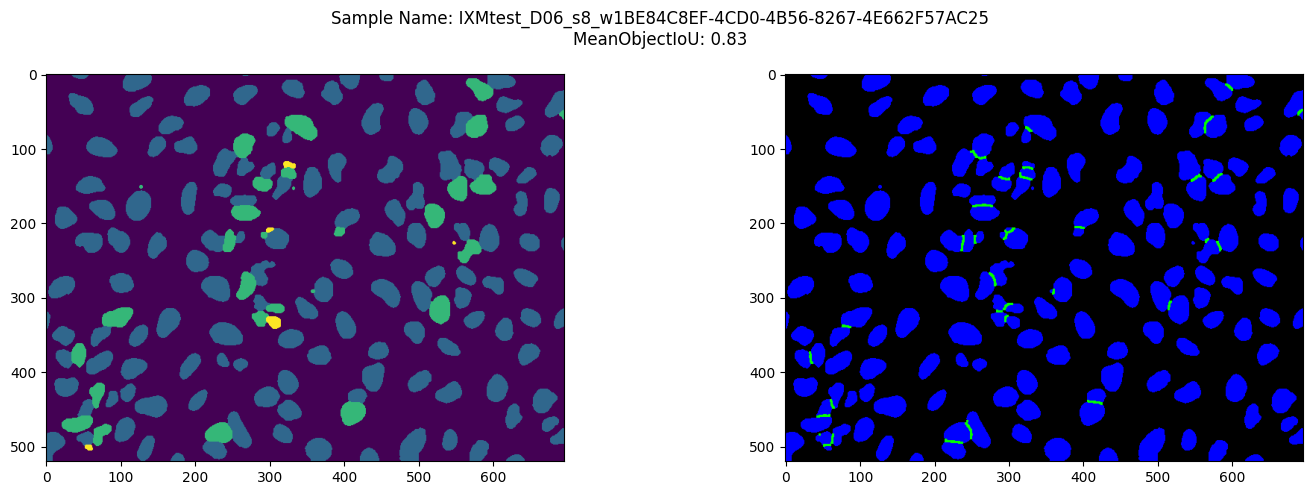

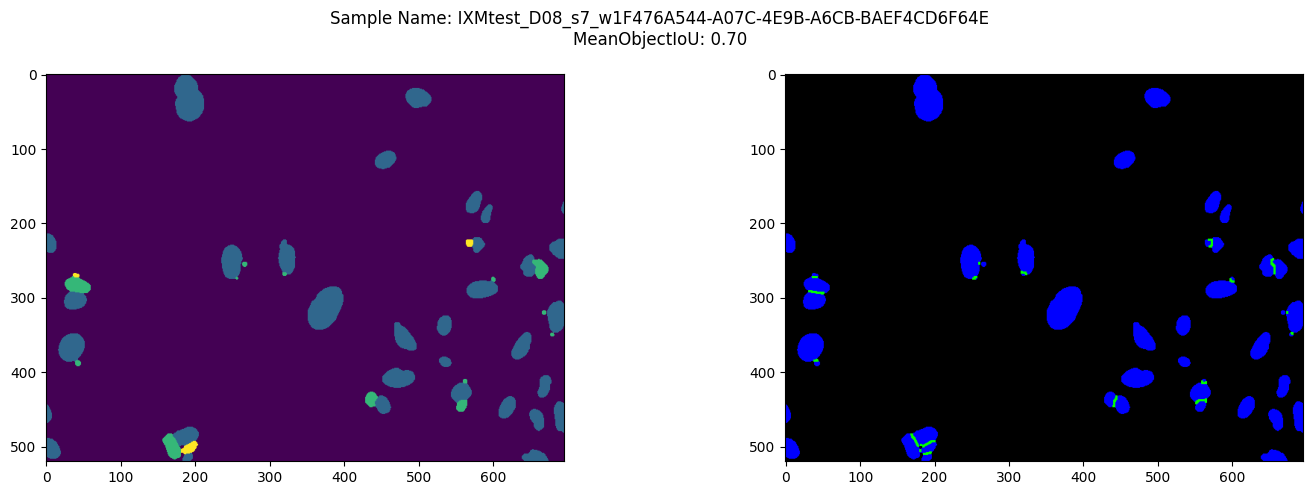

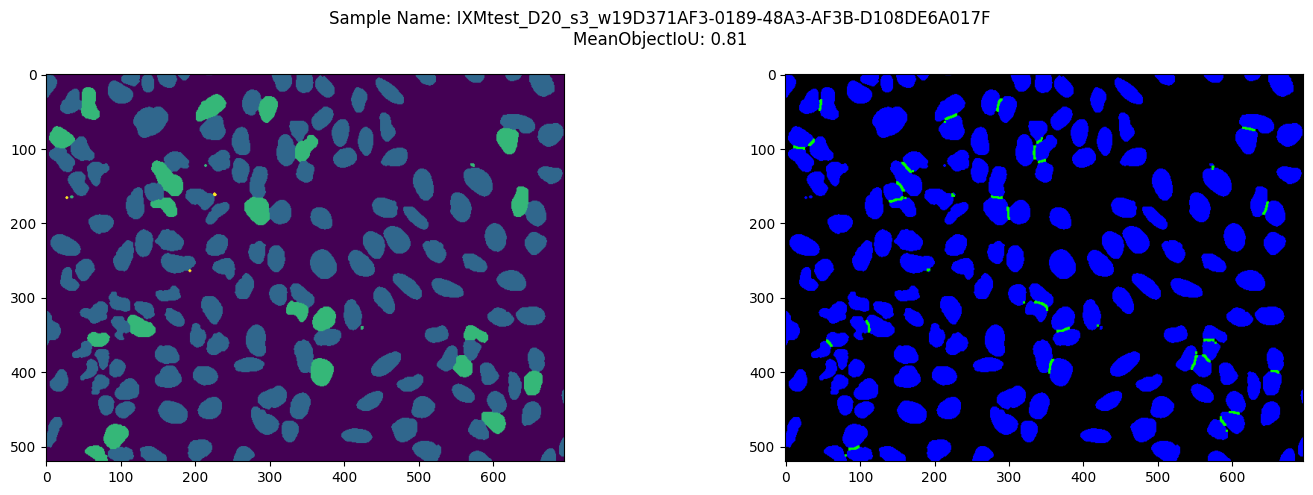

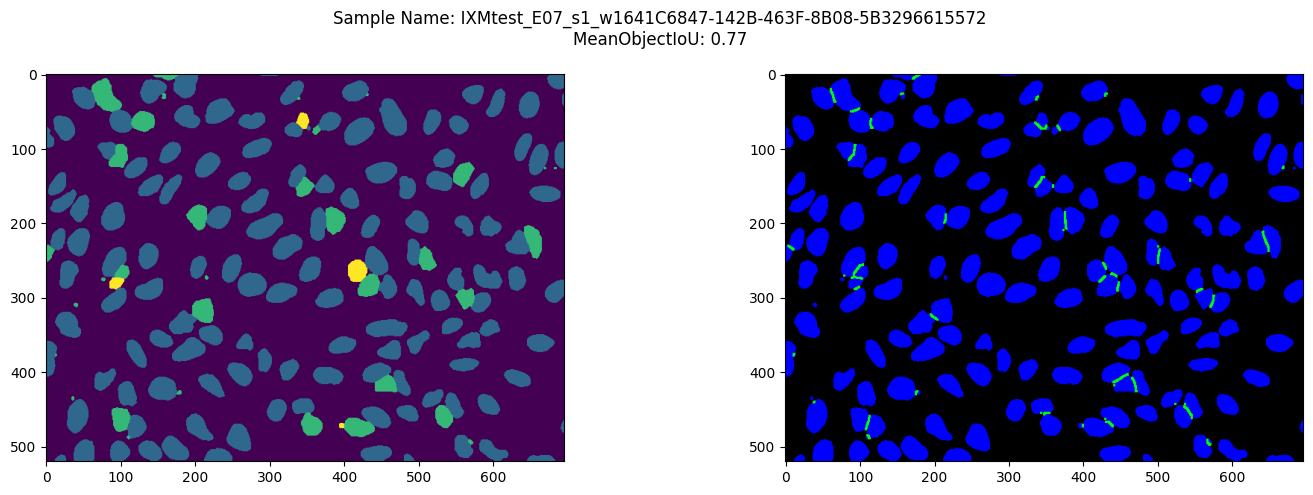

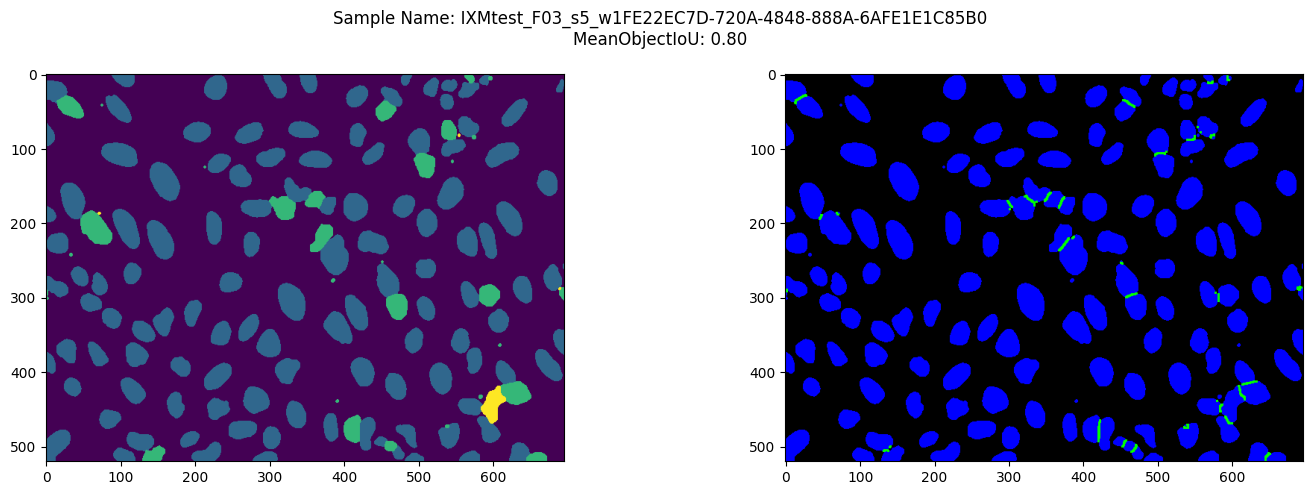

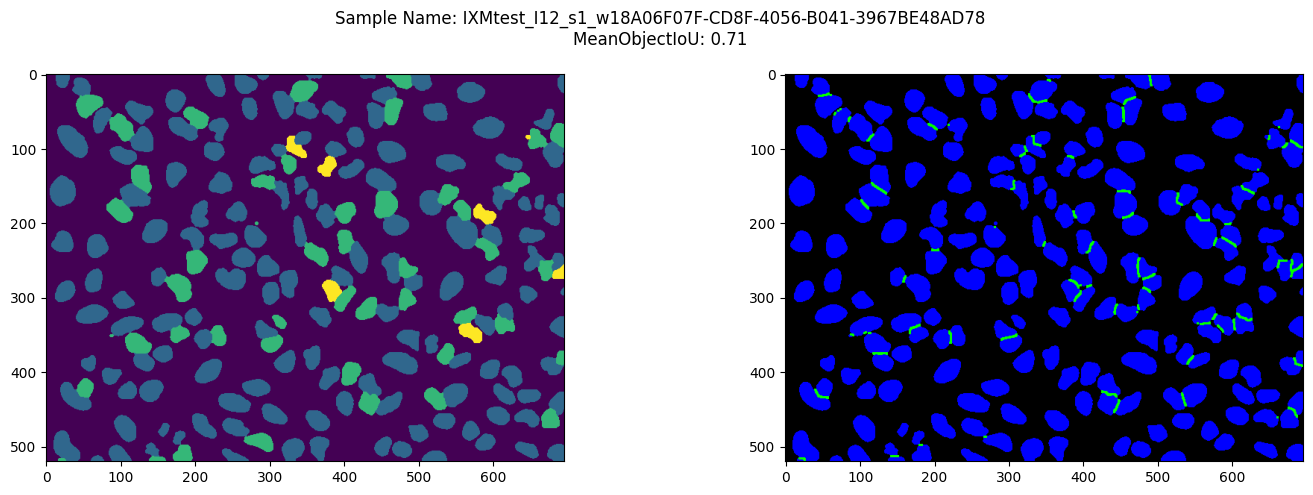

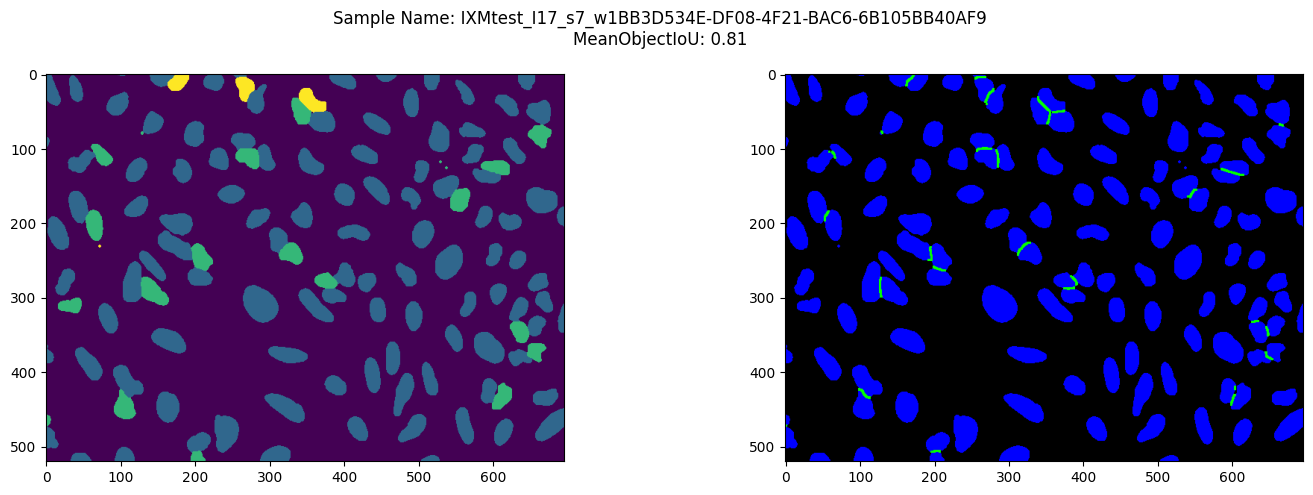

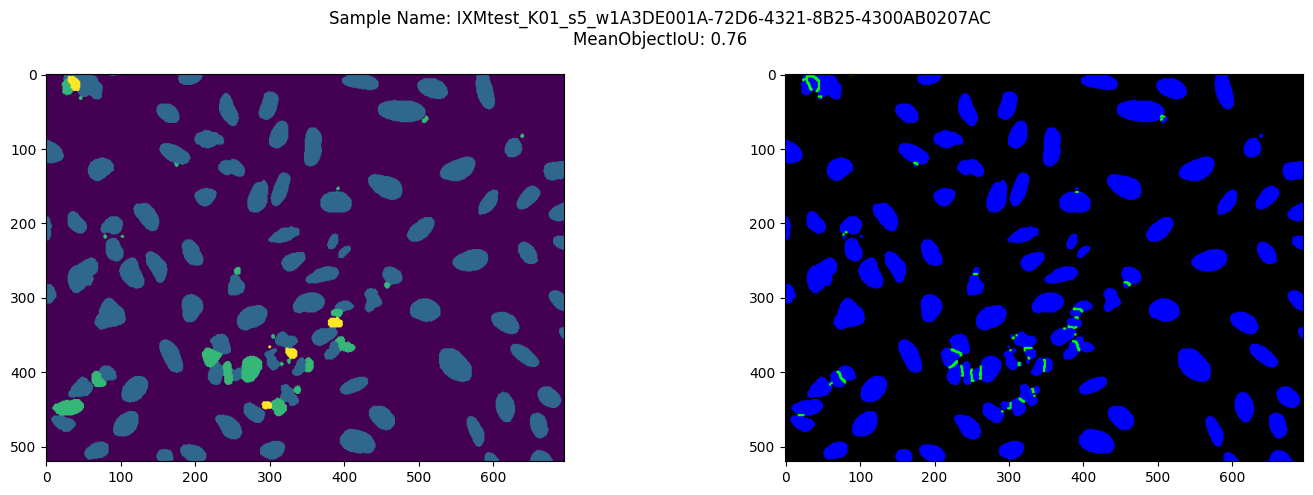

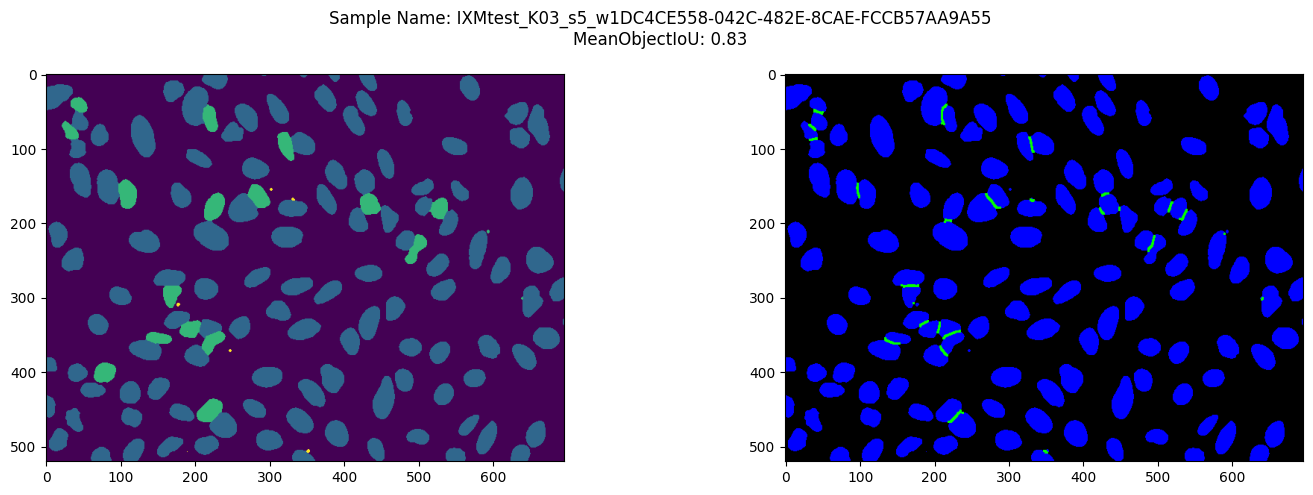

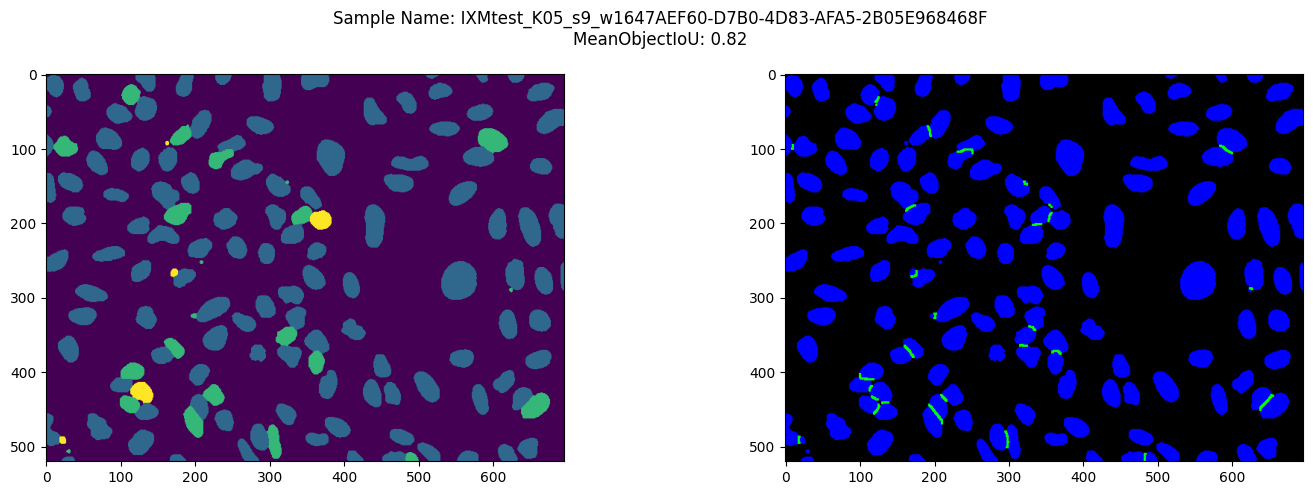

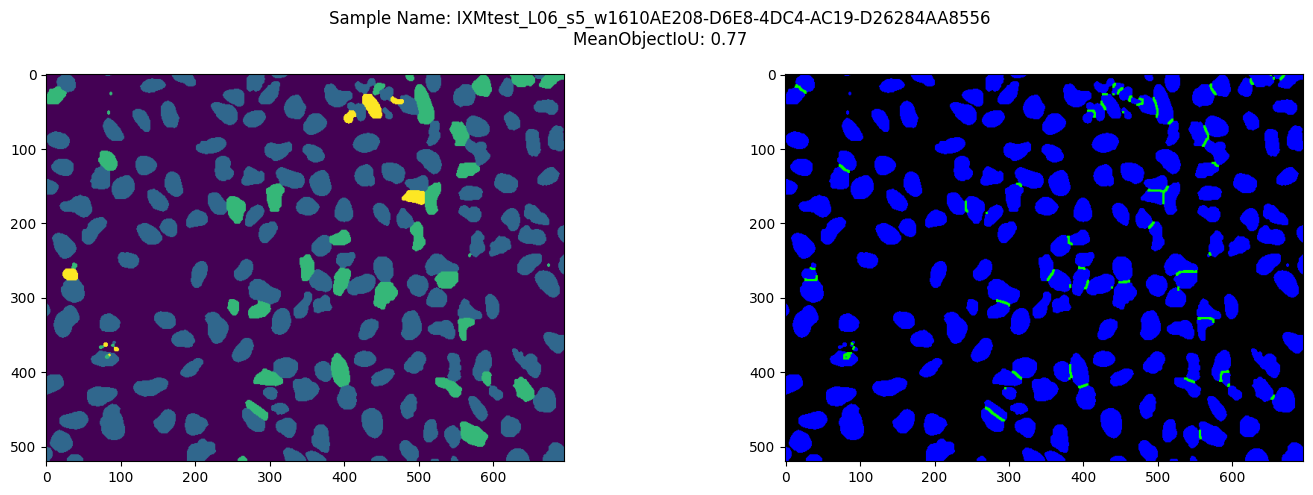

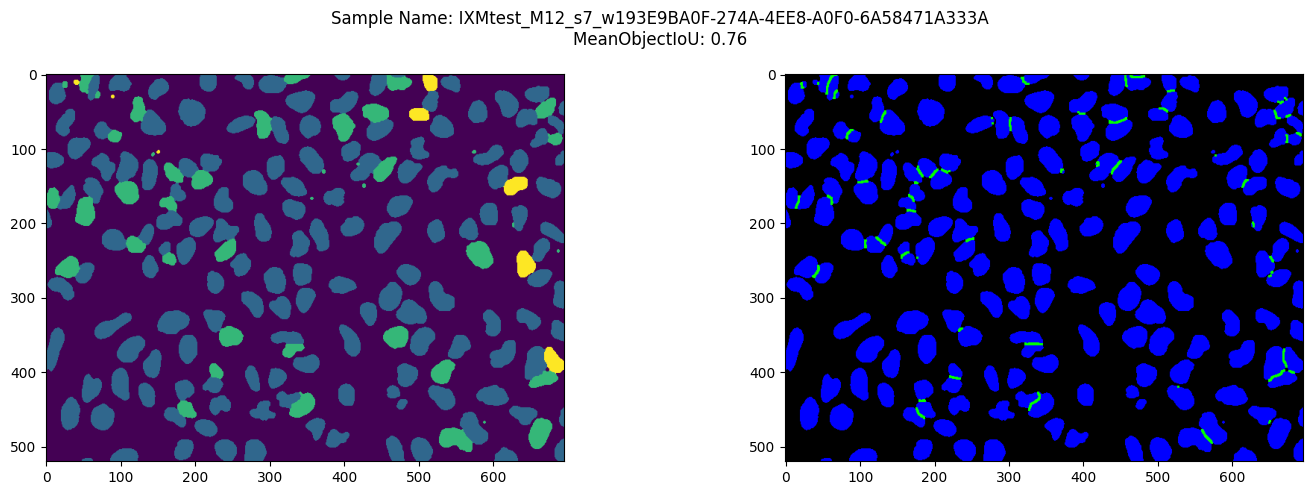

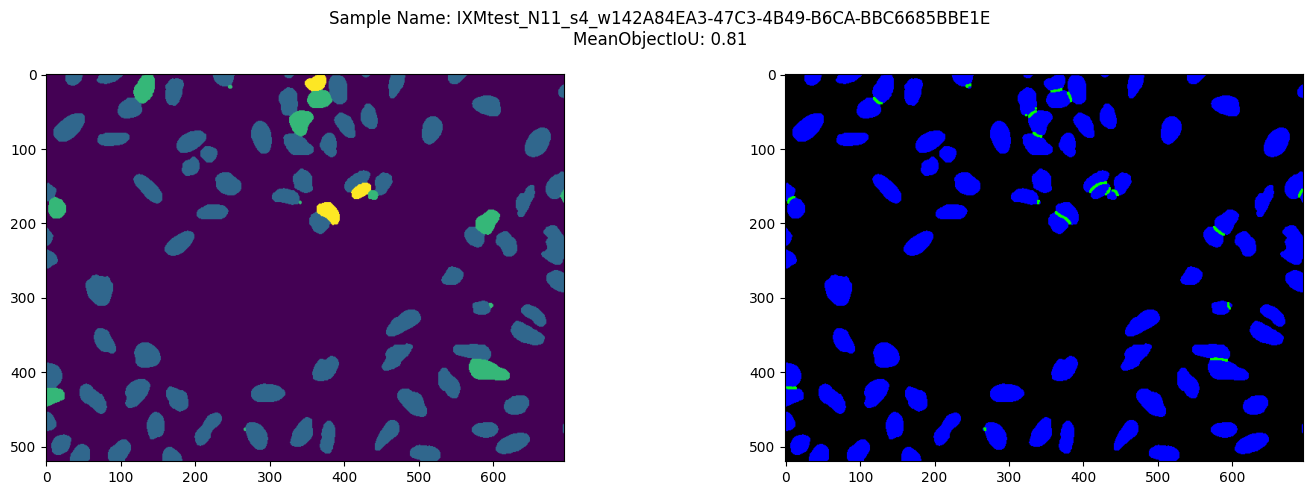

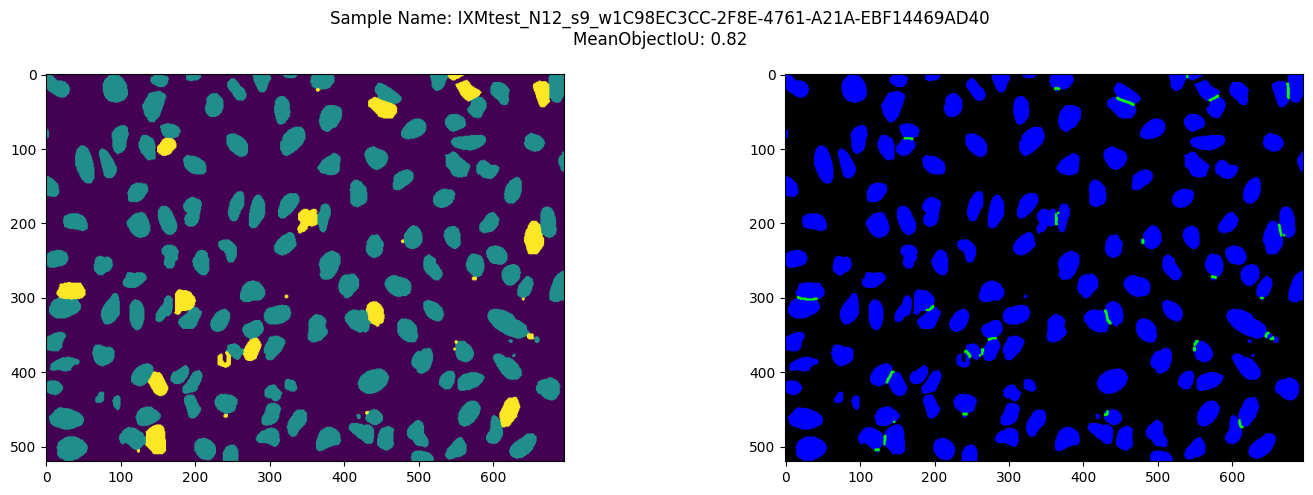

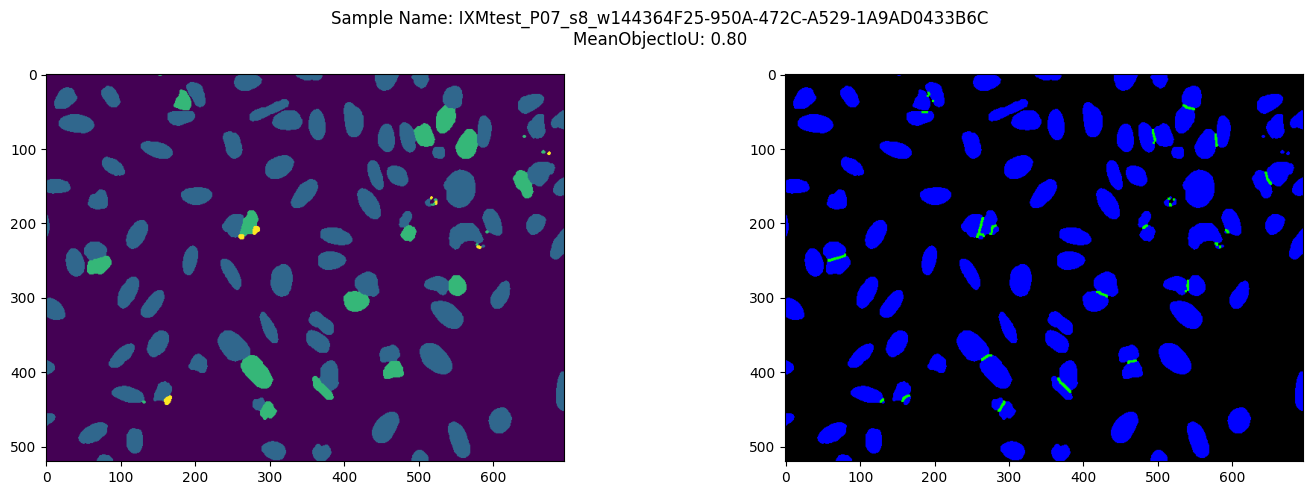

In [39]:
for _, row in df_1.iterrows(): # 18
    mask_label_raw = plt.imread(f"artifacts/evaluation/mask_label_raw_vis/{row['Sample']}.png", cv2.IMREAD_UNCHANGED)
    mask_gt = plt.imread(f"artifacts/evaluation/mask_gt_vis/{row['Sample']}.png", cv2.IMREAD_UNCHANGED)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(mask_label_raw)
    ax[1].imshow(mask_gt)
    plt.suptitle(f"Sample Name: {row['Sample']}\nMeanObjectIoU: {row['MeanObjectIoU']:.2f}")
    plt.tight_layout()
    plt.show()


#### Example of watershed

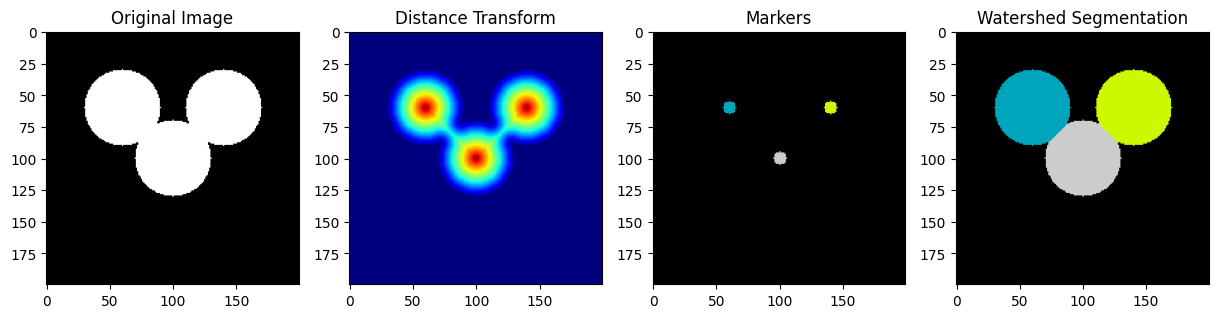

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import watershed
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from skimage.morphology import remove_small_objects

# Step 1: Create a synthetic binary image with overlapping circles
image = np.zeros((200, 200), dtype=np.uint8)
cv2.circle(image, (60, 60), 30, 255, -1)  # First circle
cv2.circle(image, (100, 100), 30, 255, -1)  # Second circle
cv2.circle(image, (140, 60), 30, 255, -1)  # Third circle

# Convert to binary mask
binary = image > 0

# Step 2: Compute distance transform (helps find object centers)
distance_map = distance_transform_edt(binary)

# Step 3: Find markers (local maxima)
markers = label(distance_map > 25)  # Threshold chosen to find centers

# Step 4: Apply the watershed algorithm
segmentation = watershed(-distance_map, markers, mask=binary)

# Step 5: Remove small objects (optional)
# segmentation = remove_small_objects(segmentation, min_size=50)

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(binary, cmap="gray")
ax[0].set_title("Original Image")

ax[1].imshow(distance_map, cmap="jet")
ax[1].set_title("Distance Transform")

ax[2].imshow(markers, cmap="nipy_spectral")
ax[2].set_title("Markers")

ax[3].imshow(segmentation, cmap="nipy_spectral")
ax[3].set_title("Watershed Segmentation")

plt.show()


#### Vis metrics

In [35]:
print(f"Mean F1: {df['F1'].mean()}")
print(f"Mean Jacard: {df['Jaccard'].mean()}")

Mean F1: 0.8706578588550714
Mean Jacard: 0.7810653334989786


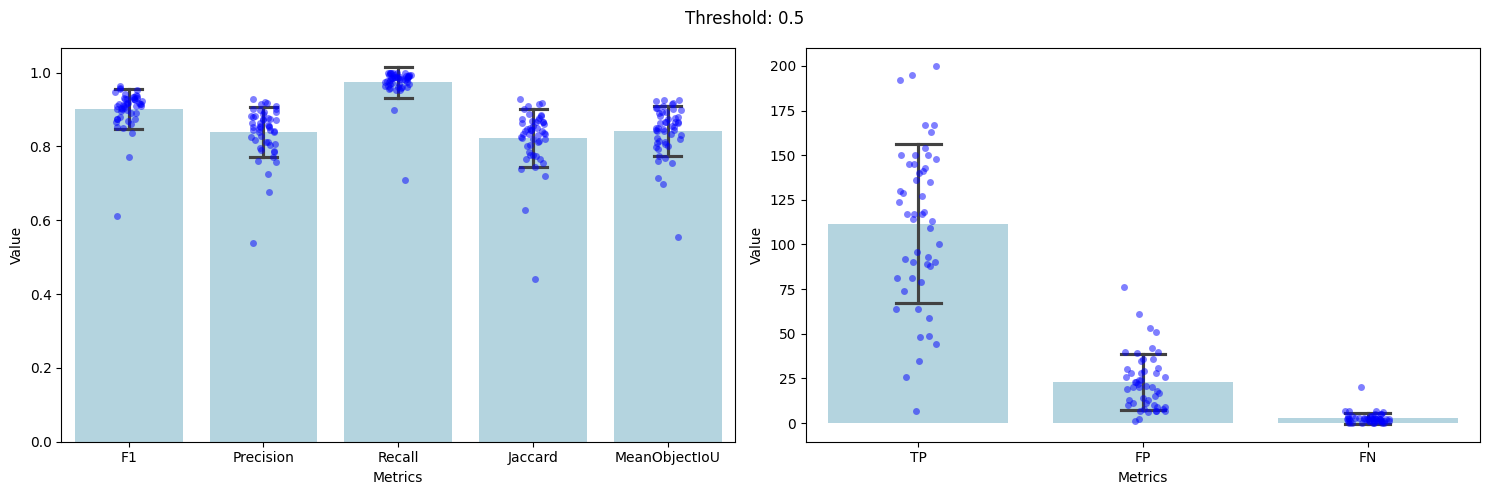

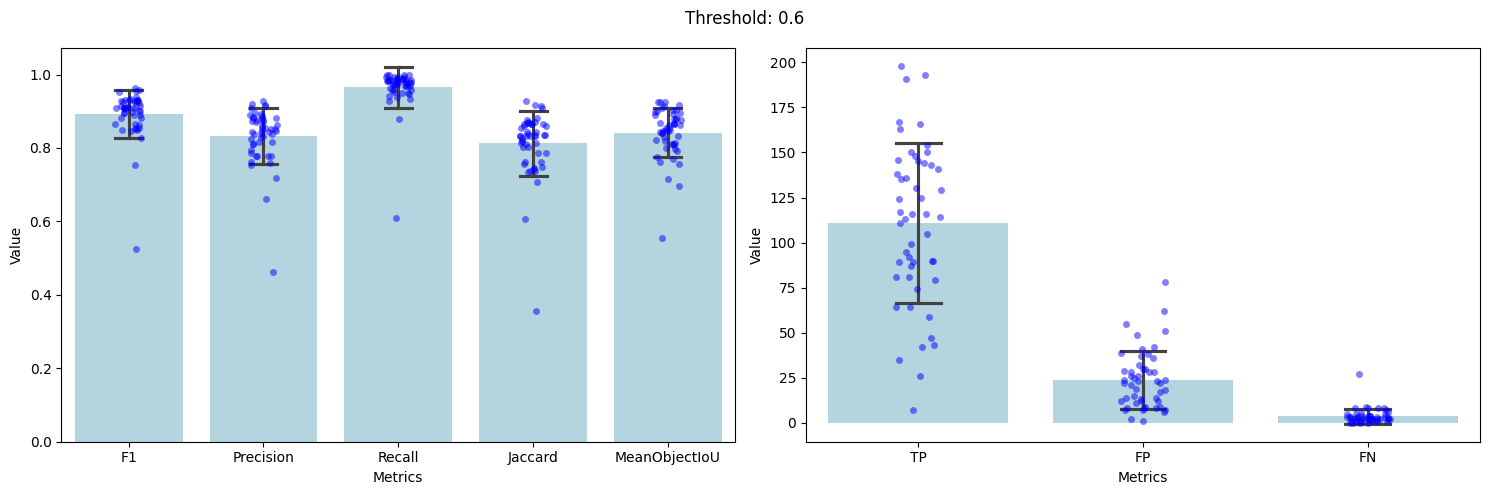

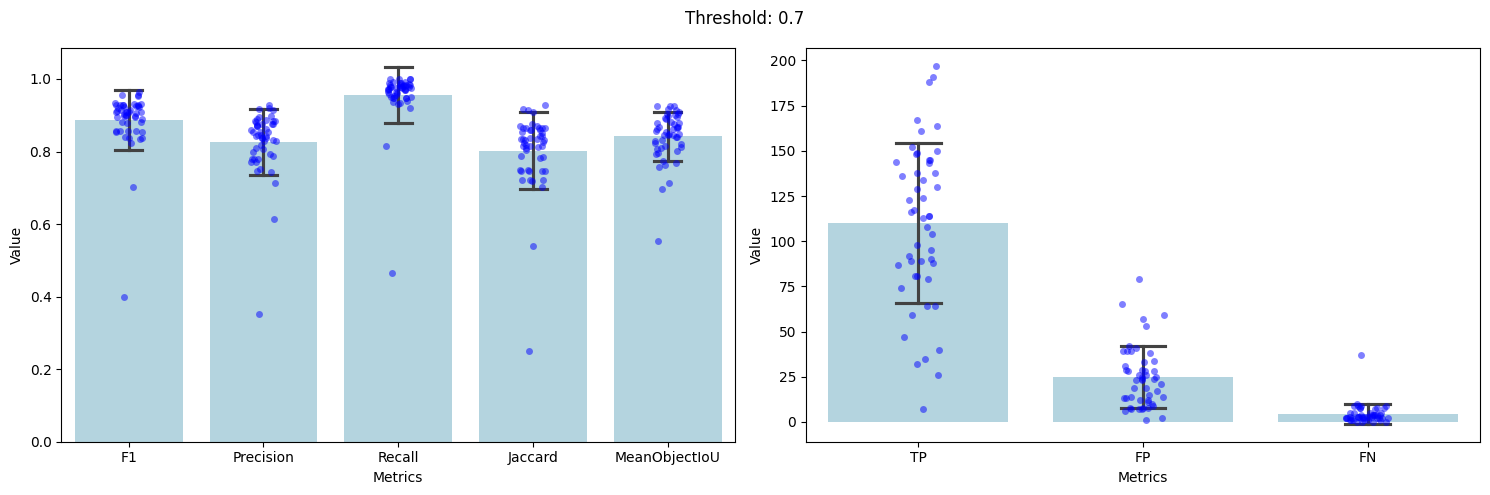

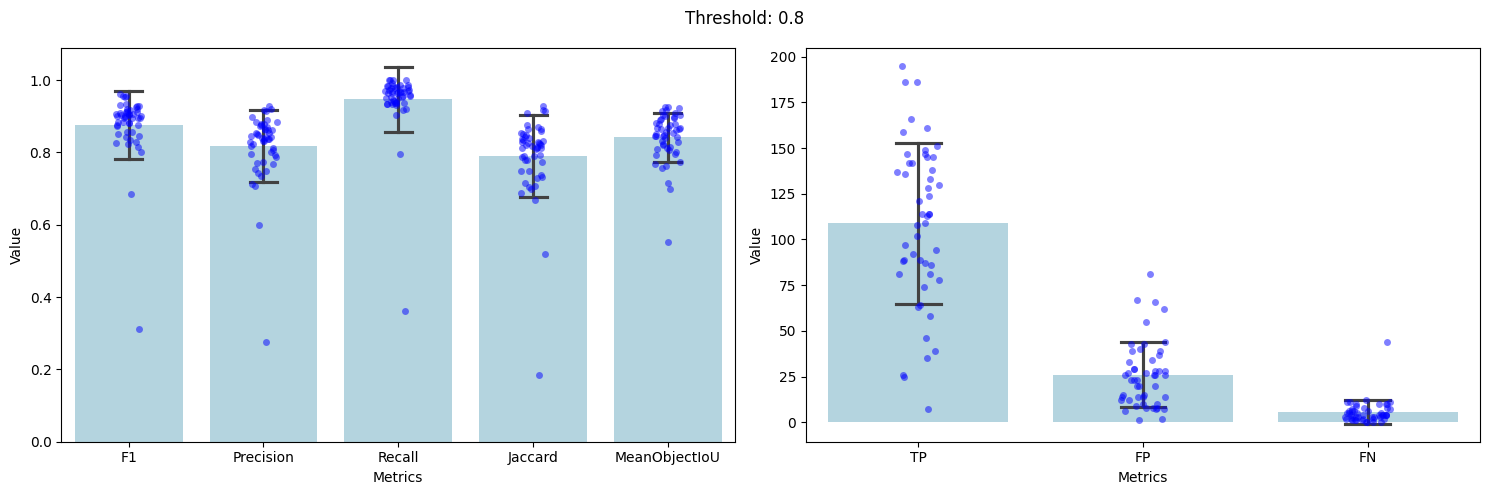

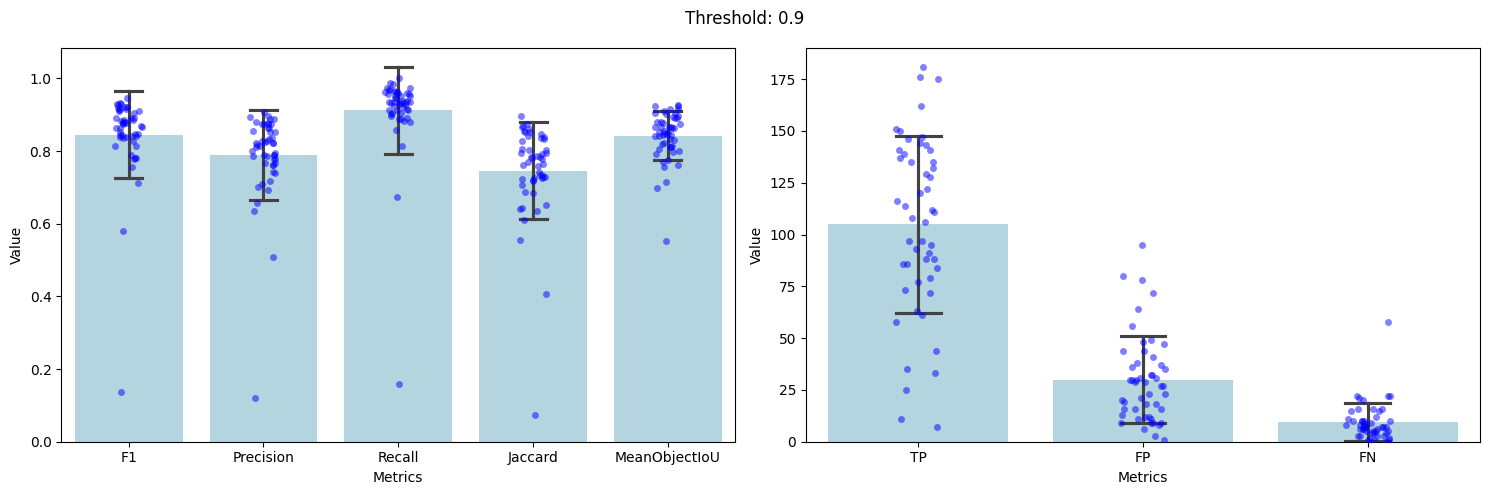

In [ ]:
vis_metrics(df)
